# Imports

In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time, datetime, itertools, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from itertools import permutations
from google.colab import files

# Helpers

In [8]:
def get_mnist_data(train_file_path, test_file_path):

  # get train-val data
  train_val_df = pd.read_csv(train_file_path)
  X_train_val = train_val_df.iloc[:, 1:]
  y_train_val = train_val_df.iloc[:, 0]

  # get test data
  test_df = pd.read_csv(test_file_path)
  X_test = test_df.iloc[:, 1:]
  y_test = test_df.iloc[:, 0]

  print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)

  return X_train_val, X_test, y_train_val, y_test


def find_n_components(X_train_val, information_percentage):
  
  pca = PCA()
  pca.fit(X_train_val)
  variance_ratios = pca.explained_variance_ratio_
  sum = variance_ratios[0]
  n_components = 1
  while sum < information_percentage:
    n_components += 1
    sum += variance_ratios[n_components-1] 
  
  return n_components

In [47]:
def preprocess_mnist_data(X_train_val, y_train_val, 
                          X_test, y_test, pca_components, 
                          train_val_split_percentage):

  # PCA train and test sets
  pca = PCA(n_components=pca_components)
  X_train_val_pca = pca.fit_transform(X_train_val)
  X_test_pca = pca.transform(X_test)

  # scale train and test sets
  scaler = MinMaxScaler()
  X_train_val_pca_scaled = scaler.fit_transform(X_train_val_pca)
  X_test_pca_scaled = scaler.transform(X_test_pca)

  # split train-val to train and validation sets
  X_train_pca_scaled, X_val_pca_scaled, y_train, y_val = train_test_split(X_train_val_pca_scaled, y_train_val,
                                                                          test_size=train_val_split_percentage, 
                                                                          shuffle=True)
  
  print(X_train_pca_scaled.shape, X_val_pca_scaled.shape, X_test_pca_scaled.shape, y_train.shape, y_val.shape, y_test.shape)

  return X_train_pca_scaled, X_val_pca_scaled, X_test_pca_scaled, y_train, y_val, y_test


def save_results_to_dict(C, gamma, kernel, time_str, train_accuracy, validation_accuracy):
  
  results_dict = {
      "dataset": "MNIST",
      "model": "SVM",
      "kernel": kernel,
      "C": C,
      "gamma": gamma,
      "N_train": 35999,
      "N_validation": 24000,
      "N_test": 9999,
      "D": 87,
      "PCA_applied": "YES",
      "k-fold Cross-Validation applied": "NO",
      "Time elapsed": time_str,
      "Train accuracy (%)": train_accuracy,
      "Validation accuracy (%)": validation_accuracy,
  }

  return results_dict


def show_image(X_test, y_test, y_test_preds, label_names, true_class, predicted_class):
  wrong_poss = np.where((y_test == true_class) & (y_test_preds == predicted_class))[0]
  random_sample = np.random.randint(low=0, high=len(wrong_poss)-1, size=1)[0]
  wrong_pos = wrong_poss[random_sample]
  random_img = X_test.iloc[wrong_pos, :].values.flatten().reshape(28,28)/255.0
  plt.imshow(random_img, interpolation='bicubic')
  plt.title(f"True class: {label_names[true_class]}\n Predicted class: {label_names[predicted_class]}")
  plt.show()

# MAIN

In [10]:
TRAIN_FILE_PATH = '/content/mnist_train.csv'
TEST_FILE_PATH = '/content/mnist_test.csv'
INFORMATION_PERCENTAGE = 0.9
TRAIN_VAL_SPLIT_PERCENTAGE = 0.4

X_train_val, X_test, y_train_val, y_test = get_mnist_data(TRAIN_FILE_PATH, TEST_FILE_PATH)
n_components = find_n_components(X_train_val, INFORMATION_PERCENTAGE)

print(f"The first {n_components} components of the PCA outcome contain at least", 
      100*INFORMATION_PERCENTAGE, "% of the information of the initial data.")

(59999, 784) (9999, 784) (59999,) (9999,)
The first 87 components of the PCA outcome contain at least 90.0 % of the information of the initial data.


In [11]:
# Preprocess data
X_train_pca_scaled, X_val_pca_scaled, X_test_pca_scaled, \
y_train, y_val, y_test = preprocess_mnist_data(X_train_val.values, y_train_val.values, 
                                               X_test.values, y_test.values, n_components, 
                                               TRAIN_VAL_SPLIT_PERCENTAGE)

(35999, 87) (24000, 87) (9999, 87) (35999,) (24000,) (9999,)


In [12]:
kernel = 'rbf'
C_list = [10]
gamma_list = [1]
results = []
for i, C in enumerate(C_list):
  for j, gamma in enumerate(gamma_list):
    print(f"**************** C = {C}, gamma = {gamma} ****************")

    # start time
    tic = time.time()

    # create and fit our SVM model
    svm = SVC(C=C, gamma=gamma, kernel=kernel, decision_function_shape='ovo')
    svm.fit(X_train_pca_scaled, y_train)

    # Get predictions and check accuracy on the Training set
    y_train_preds = svm.predict(X_train_pca_scaled)
    train_accuracy = float("{:.2f}".format(100 * np.mean(y_train_preds == y_train)))
    print(f"train_accuracy = {train_accuracy} %")

    # Get predictions and check accuracy on the Validation set
    y_val_preds = svm.predict(X_val_pca_scaled)
    val_accuracy = float("{:.2f}".format(100 * np.mean(y_val_preds == y_val)))
    print(f"val_accuracy = {val_accuracy} %")
    
    # end time
    toc = time.time()

    # turn total time from seconds to -> hours, minutes and seconds
    Dt = toc - tic
    total_time = str(datetime.timedelta(seconds=Dt))
    time_split = total_time.split(':')
    hours = int(time_split[0])
    minutes = int(time_split[1])
    seconds = round(float(time_split[2]))
    time_str = str(hours) + 'h  ' + str(minutes) + 'min  ' + str(seconds) + 'sec'

    results_dict = save_results_to_dict(C, gamma, kernel, time_str, train_accuracy, val_accuracy)
    results.append(results_dict)
    print(f"Time elapsed = {hours}h {minutes}min {seconds}sec \n")

**************** C = 10, gamma = 1 ****************
train_accuracy = 100.0 %
val_accuracy = 98.21 %
Time elapsed = 0h 2min 25sec 



In [13]:
# Get predictions on the Test set
y_test_preds = svm.predict(X_test_pca_scaled)
test_accuracy = float("{:.2f}".format(100 * np.mean(y_test_preds == y_test)))
print(f"test_accuracy = {test_accuracy} %")

test_accuracy = 98.14 %


In [ ]:
# results_df = pd.DataFrame(results)
# results_df.to_excel("MNIST_rbf.xlsx")
# files.download("MNIST_rbf.xlsx")

# Visualizations

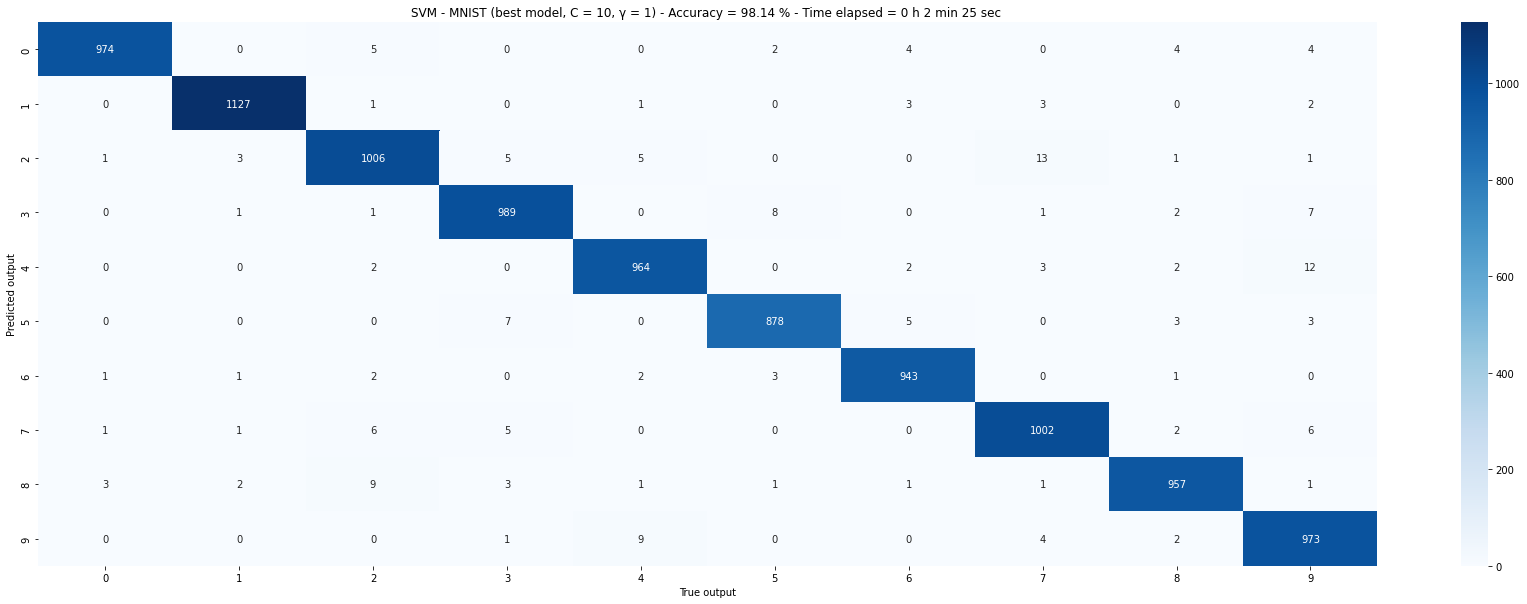

In [14]:
confusionMatrix = confusion_matrix(y_test_preds, y_test)

plt.figure(figsize=(30, 10))
plt.title(f"SVM - MNIST (best model, C = {C}, γ = {gamma}) - Accuracy = {test_accuracy} % - Time elapsed = {hours} h {minutes} min {seconds} sec ")
ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues', fmt='d')
ax.set(xlabel='True output', ylabel='Predicted output')
plt.show()

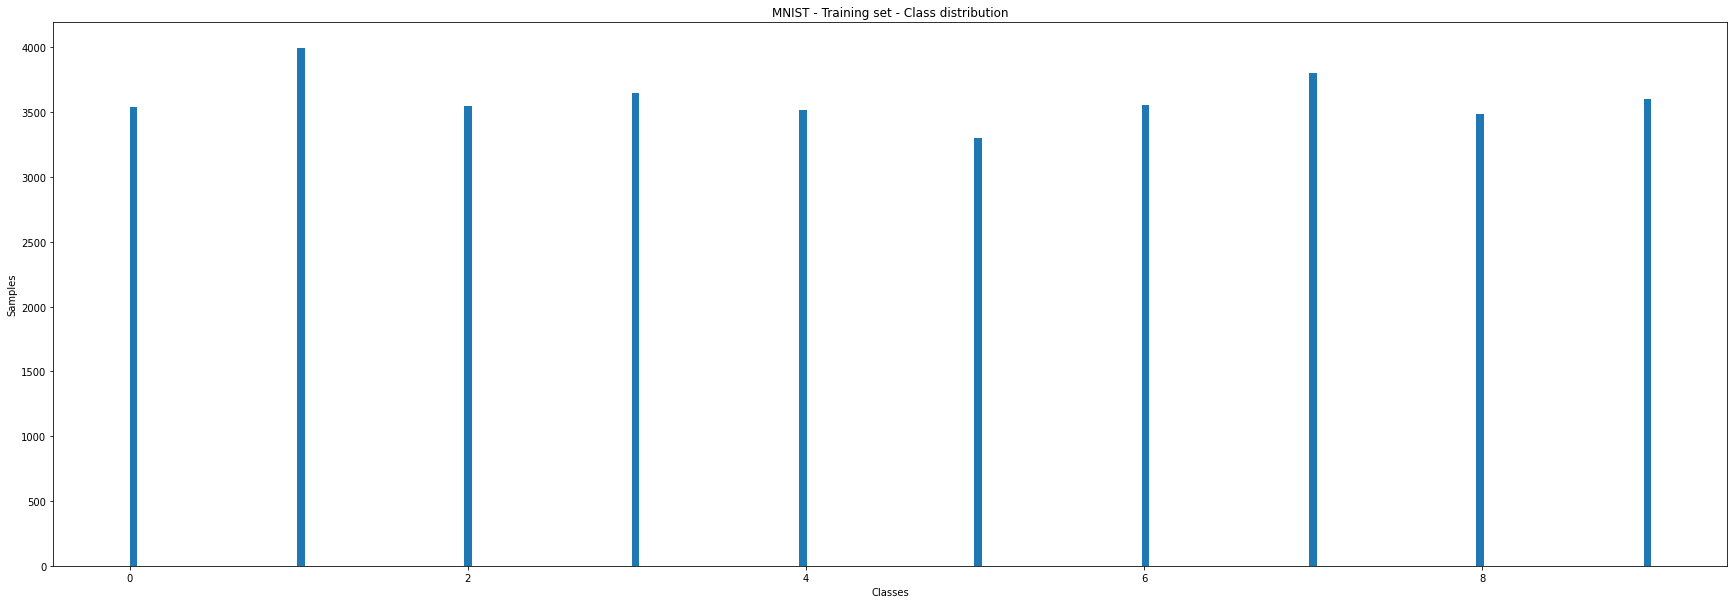

In [65]:
plt.figure(figsize=(30, 10))
plt.hist(y_train, bins=200)
plt.xlabel("Classes")
plt.ylabel("Samples")
plt.title("MNIST - Training set - Class distribution")
plt.show()

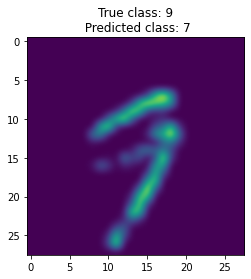

In [99]:
true_class = 9
predicted_class = 7
show_image(X_test, y_test, y_test_preds, list(np.arange(10)), true_class, predicted_class)

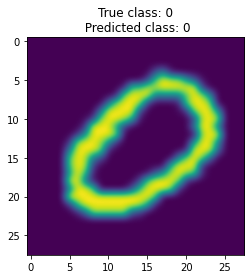

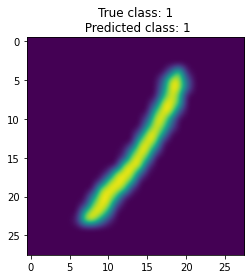

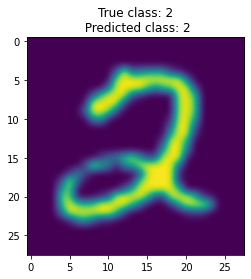

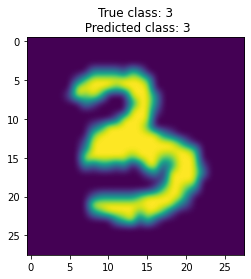

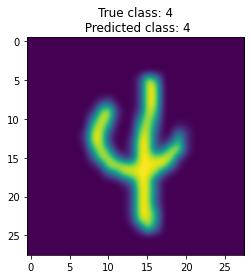

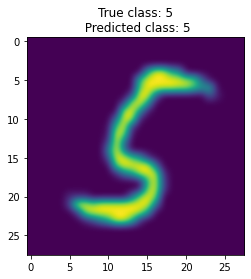

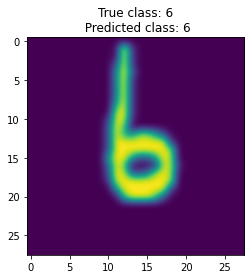

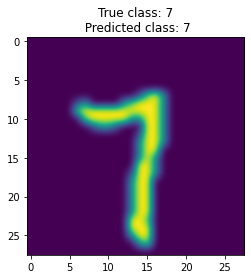

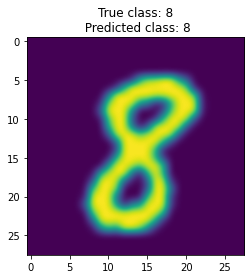

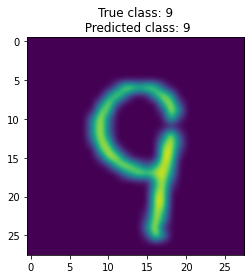

In [100]:
for n_class in range(10):
  true_class, predicted_class = n_class, n_class
  show_image(X_test, y_test, y_test_preds, list(np.arange(10)), true_class, predicted_class)